In [1]:
# Para evitar algunos cuadros de diálogo
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Se importan las librerias a utilizar
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

In [3]:
# gen_initial_perm: Genera una permutacion inicial
# Dada una matriz de adyacencia A, genera la permutacion de vertices sigma, donde
# sigma es la permutacion donde los nodos estan en orden decreciente segun su grado
def gen_initial_perm(A):
    grados = np.zeros(A.shape[0])
    #grados = np.apply_along_axis(sum, 1, A)
    
    return np.flip(np.argsort(grados)) #argsort retorna los indices que ordenan la lista, justo lo que queremos 

In [4]:
# Se genera un grafo aleatorio para testear el algoritmo
# Este es un testeo muy basico y que no se incluyo en la presentación ni los resultados
G = nx.fast_gnp_random_graph(50,0.4)
L = nx.adjacency_matrix(G).todense()
s = gen_initial_perm(L)
dict_t = {}
for i in range(s.size):
    dict_t[s[i]] = str(i)

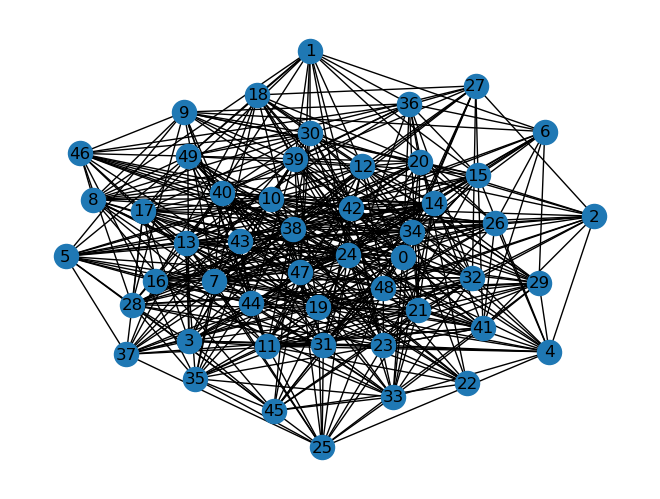

In [5]:
#Se dibujo el grafos
nx.draw(G, labels=dict_t)

In [6]:
# graph_clique : Dibujo el grafo dado y resalta el m-clique dado
# G es el grafo, m es el tamano del clique, sigma es la permutacion de los nodos donde
# sus primeras m entradas son las entradas del clique}
# se advierte que esta funcion solo dibuja, no revisa si efectivamente existe el clique
def graph_clique(G,m,sigma):
    pos = nx.spring_layout(G)
    #print(sigma_lol)
    nodes = {
        'r': sigma[0:m],
        'b': sigma[m:]
    }
    aristas = []
    for i in range(m-1):
        for j in range(i,m):
            aristas.append( (sigma[i],sigma[j]) )

    for node_color, nodelist in nodes.items():
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=node_color, node_size = 25)

    labels = {x: x for x in G.nodes}
    #nx.draw_networkx_labels(G, pos, labels, font_size='0', font_color='w')
    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    nx.draw_networkx_edges(G,pos,
                           edgelist=aristas,
                           width=1.5,alpha=0.8,edge_color='r')

# Primera implementación del SA para m-clique

In [7]:
# F : Funcion objetivo a minimizar
# A es matriz de adyacencia, sigma es una permutacion de los nodos, m es el tamano del clique
# F cuenta la cantidad de nodos entre los primeros m vertices de sigma en el grafo complemento
def F(A, sigma,m):
    h = 0
    for k in range(m-1):
        for l in range(k+1,m):
            h += 1 - A[sigma[k],sigma[l]]
    return h

# F_prima : Funcion auxiliar usada para encontrar vecino
# A es matriz de adyacencia, z es algun indice de algun nodo, m el tamano del clique
# F_prima cuenta cuantos nodos existen entre el nodo z y los demas primeros m nodos de sigma
def F_prima(z,A,m):
    l = 0
    for i in range(m):
        if i == z: continue
        
        l += A[i,z]
    
    return l
    
# vecino:
# Dada una permutacion, entregua un vecino el cual se obtiene siguiendo las reglas del paper
# m es el numero del clique que se busca, A es matriz de adyacencia
def vecino(sigma,m,A):
    n = A.shape[0]
    new_sig = sigma.copy()
    
    u = np.random.randint(0,m)
    w = np.random.randint(m,n)
    contador = 0
    
    #Restricting Condition - Criterio de busqueda local
    #Se acepta vecino si mejora la solucion
    while F_prima(u,A,m) > F_prima(w,A,m):
        contador += 1
        if contador >= 8*n: # se acepta de todas formas
            break
            
        w = np.random.randint(m,n)
    
    new_sig[u] = sigma[w]
    new_sig[w] = sigma[u]
    
    return new_sig

In [8]:
#Decision_SA : Resuelve el problema de decision de m-clique con SA
# m es el tamano del clique, steps es la cantidad maxima de pasos que SA realiza
# A es la matriz de adyacencia del grafo, beta funcion de temperatura
def Decision_SA(m,steps,A,beta):
    # Se genera permutacion inicial
    # sigma sera la variable donde se guardara la permutacion actual del simulated annealing
    # cost sera la variable donde se guardara el costo actual del simulated annealing
    sigma = gen_initial_perm(A)
    cost = F(A,sigma,m)
    
    for n in range(steps):
        
        #Se genera el numero pseudo aleatorio
        u = np.random.uniform(0, 1)
        
        #Se obtiene vecino y se calcula su costo
        # sigma_new sera el nuevo vecino
        # cost_new sera el costo del nuevo vecino
        sigma_new = vecino(sigma,m,A)
        cost_new =  F(A,sigma_new,m)
        
        #Se acepta si tiene costo 0, conocemos a priori que tal valor es el unico optimo de la funcion
        if cost_new == 0:
            sigma = sigma_new
            break
        else:
            #Se realiza la transicion de acuerdo a la temperatura
            cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))
            
            if u <= cte:
                #Se actualiza
                sigma = sigma_new
                cost = cost_new
                
    return (sigma_new, n)

## Probando el algoritmo

In [9]:
#Se define esquema de temperatura exponencial
def beta_lol(n):
    return np.exp(n/10000)

#Se prueba, testeo basico para verificar que el algoritmo funciona
sigma_lol, n_lol = Decision_SA(6,1000000,L,beta_lol)
print(n_lol)

999999


In [10]:
### Beta paper, en realidad no se uso mucho ya que es exponencial al igual que el beta anterior
alpha = 0.9996
def betap(n):
    return (1)/(100*(alpha**n))

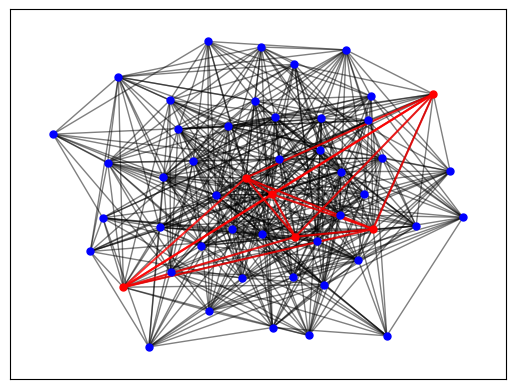

In [11]:
#Se testea
graph_clique(G,6,sigma_lol)

In [12]:
#Clique encontrado por SA
print(sigma_lol[0:6])

[47 48 24 17 15 23]


In [13]:
#Clique aproximado por el algoritmo de aproximacion 
#Notese que es algoritmo de aproximacion, por ende no entrega el clique maximal que es de 6
# sino que entrega un clique de tamano 5
nx.approximation.max_clique(G)

{1, 9, 20, 23, 33}

In [14]:
#Clique encontrado por el algoritmo exacto
#Notese que este algoritmo al ser exacto, no es de tiempo polinomial
#Se le agregan pesos a los vertices del grafo ya que este algoritmo exacto es de clique con peso
for node in G.nodes():
    G.nodes[node]['weight'] = 1

nx.algorithms.max_weight_clique(G)

([29, 16, 0, 45, 14, 35], 6)

## Leyendo grafos de DIMAC 

In [15]:
# read_DIMAC: recibe como input la direccion de un archivo de un grafo dimac en formato ascii
# y entrega un grafo de NetworkX que corresponde al grafo del archivo
def read_DIMAC(archivo):
    edges_d = []
    
    #Se lee linea por linea
    with open(archivo) as f:
        lines = f.readlines()

    
    for line in lines:
        #Se ignoran las lineas que no representan aristas (e)
        if line[0] != 'e':
            continue
    
        #Se separa el string en partes, y a partir de eso se reconstruye la arista
        edges_tmp = line[2:].strip().split() 
        for i in range(2):
            edges_tmp[i] =  int(edges_tmp[i]) - 1
        
        edges_d.append(edges_tmp )
    
    #Con lo anterior se construye el correspondiente grafo en NetworkX
    g = nx.Graph()
    g.add_edges_from(edges_d)

    return g

In [16]:
#Leyendo C125.9
C125 = read_DIMAC("dimacs_graphs/C125.9.clq")

for node in C125.nodes():
    C125.nodes[node]['weight'] = 1

In [17]:
#Ejecutando el algoritmo en C125.9 con esquema de temperatura expoenncial
sigma_lol, n_lol = Decision_SA(34,100000,nx.adjacency_matrix(C125).todense(),beta_lol)
print(n_lol)

24637


In [18]:
#Confirmando que funciona, se vuelve a ejecutar el algoritmo n_trials veces en el C125.9 
# con fines estadisticos
count_fails = 0
n_trials = 15
for k in range(n_trials):
    print("En iteracion ", k)
    sigma_lol, n_lol = Decision_SA(34,100000,nx.adjacency_matrix(C125).todense(),beta_lol)
    #Si sucede esta condicion, fallo el algoritmo
    if n_lol >= 100000-1:
        count_fails += 1

print("El algoritmo fallo", count_fails/n_trials * 100, "% de veces")

En iteracion  0
En iteracion  1
En iteracion  2
En iteracion  3
En iteracion  4
En iteracion  5
En iteracion  6
En iteracion  7
En iteracion  8
En iteracion  9
En iteracion  10
En iteracion  11
En iteracion  12
En iteracion  13
En iteracion  14
El algoritmo fallo 20.0 % de veces


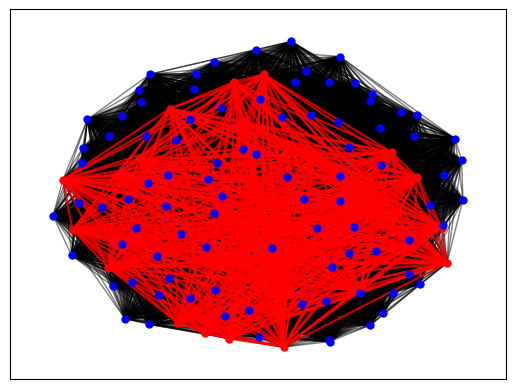

In [19]:
#Se grafica, pero dado lo gigante del grafico no tiene mucho sentido hacerlo xd
graph_clique(C125,34,sigma_lol)

In [20]:
#Se confirma el clique maximo con el algoritmo exacto
nx.algorithms.max_weight_clique(C125)

([82,
  67,
  92,
  70,
  121,
  120,
  116,
  78,
  43,
  114,
  30,
  4,
  0,
  47,
  24,
  8,
  1,
  122,
  76,
  33,
  69,
  17,
  48,
  84,
  28,
  10,
  109,
  100,
  81,
  79,
  6,
  113,
  59,
  53],
 34)

In [21]:
#Leyendo gen400_p0.9_65.clq
gen400 = read_DIMAC("dimacs_graphs/gen400_p0.9_65.clq")

for node in gen400.nodes():
    gen400.nodes[node]['weight'] = 1

In [22]:
#Se prueba
sigma_lol, n_lol = Decision_SA(45,100000,nx.adjacency_matrix(gen400).todense(),beta_lol)
print(n_lol)

71505


In [23]:
#Confirmando que funciona, se vuelve a ejecutar el algoritmo n_trials veces en el gen400 
# con fines estadisticos
count_fails = 0
n_trials = 5
for k in range(n_trials):
    print("En iteracion ", k)
    sigma_lol, n_lol =  Decision_SA(65,100000,nx.adjacency_matrix(gen400).todense(),betap)
    print(n_lol)
    if n_lol >= 100000-1:
        count_fails += 1

print("El algoritmo fallo", count_fails/n_trials * 100, "% de veces")

En iteracion  0
99999
En iteracion  1
99999
En iteracion  2
99999
En iteracion  3
99999
En iteracion  4
99999
El algoritmo fallo 100.0 % de veces


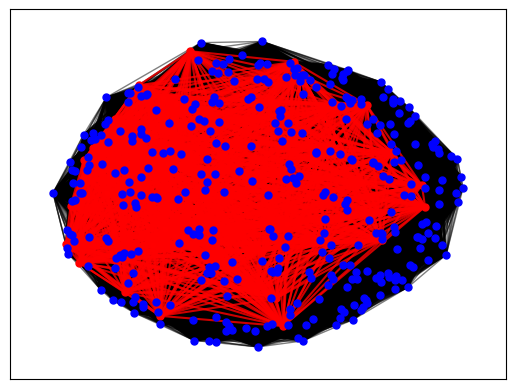

In [24]:
graph_clique(gen400,45,sigma_lol)

In [25]:
#Leyendo brock400_2.clq
brock400_2 = read_DIMAC("dimacs_graphs/brock400_2.clq")

for node in brock400_2.nodes():
    brock400_2.nodes[node]['weight'] = 1

In [26]:
sigma_lol, n_lol = Decision_SA(29,100000,nx.adjacency_matrix(brock400_2).todense(),betap)
print(n_lol)

99999


In [27]:
#Confirmando que funciona, se vuelve a ejecutar el algoritmo n_trials veces en el brock400_2
# con fines estadisticos
count_fails = 0
n_trials = 5
for k in range(n_trials):
    print("En iteracion ", k)
    sigma_lol, n_lol =  Decision_SA(29,100000,nx.adjacency_matrix(brock400_2 ).todense(),betap)
    print(n_lol)
    if n_lol >= 100000-1:
        count_fails += 1

print("El algoritmo fallo", count_fails/n_trials * 100, "% de veces")

En iteracion  0
99999
En iteracion  1
99999
En iteracion  2
99999
En iteracion  3
99999
En iteracion  4
99999
El algoritmo fallo 100.0 % de veces


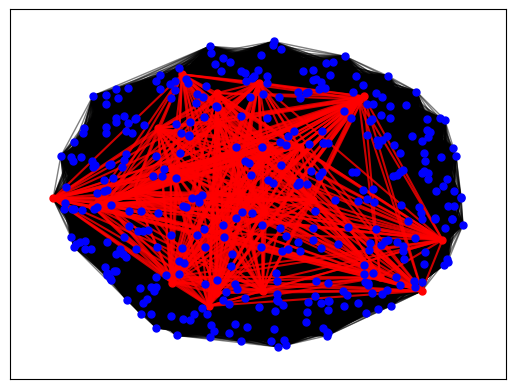

In [28]:
graph_clique(brock400_2,29,sigma_lol)

In [29]:
#Leyendo keller4.clq
keller4 = read_DIMAC("dimacs_graphs/keller4.clq")

for node in keller4.nodes():
    keller4.nodes[node]['weight'] = 1

In [30]:
#Confirmando que funciona, se vuelve a ejecutar el algoritmo n_trials veces en el keller4
# con fines estadisticos
count_fails = 0
n_trials = 15
for k in range(n_trials):
    print("En iteracion ", k)
    sigma_lol, n_lol =  Decision_SA(11,100000,nx.adjacency_matrix(keller4).todense(),betap)
    print(n_lol)
    if n_lol >= 100000-1:
        count_fails += 1

print("El algoritmo fallo", count_fails/n_trials * 100, "% de veces")

En iteracion  0
20613
En iteracion  1
17256
En iteracion  2
23267
En iteracion  3
19546
En iteracion  4
21023
En iteracion  5
22780
En iteracion  6
18250
En iteracion  7
19913
En iteracion  8
17723
En iteracion  9
20522
En iteracion  10
20821
En iteracion  11
16607
En iteracion  12
20308
En iteracion  13
18952
En iteracion  14
99999
El algoritmo fallo 6.666666666666667 % de veces


In [31]:
#Leyendo p_hat300-1
phat = read_DIMAC("dimacs_graphs/p_hat300-1.clq")

for node in phat.nodes():
    phat.nodes[node]['weight'] = 1

In [32]:
#Confirmando que funciona, se vuelve a ejecutar el algoritmo n_trials veces en p_hat300-1
# con fines estadisticos
count_fails = 0
n_trials = 15
for k in range(n_trials):
    print("En iteracion ", k)
    sigma_lol, n_lol =  Decision_SA(8,100000,nx.adjacency_matrix(phat).todense(),betap)
    print(n_lol)
    if n_lol >= 100000-1:
        count_fails += 1

print("El algoritmo fallo", count_fails/n_trials * 100, "% de veces")

En iteracion  0
17694
En iteracion  1
99999
En iteracion  2
16182
En iteracion  3
99999
En iteracion  4
99999
En iteracion  5
99999
En iteracion  6
99999
En iteracion  7
99999
En iteracion  8
99999
En iteracion  9
99999
En iteracion  10
99999
En iteracion  11
99999
En iteracion  12
99999
En iteracion  13
99999
En iteracion  14
99999
El algoritmo fallo 86.66666666666667 % de veces


## Generando estadisticas

In [33]:
#Se genera un grafo aleatorio pequeno, de 50 nodos, con probabilidad de arista uniformes
#el objetivo es comparar temperatura cuadratica con exponencial
G = nx.fast_gnp_random_graph(50,0.5)
L = nx.adjacency_matrix(G).todense()

#Clique encontrado por el algoritmo exacto
for node in G.nodes():
    G.nodes[node]['weight'] = 1

#Se almacena el max_clique
rand_maxcliq = nx.algorithms.max_weight_clique(G)[-1]

In [34]:
# get_estadisticas_decision : 
# Dado un grafo, ejecuta el SA, retornando un vector del numero de pasos que se demoro en terminar
# si es que termino de manera exitosa, si no termina de manera exitosa, se vuelve a ejecutar el algoritmo
def get_estadisticas_decision(A,m,max_step,beta,times):
    contador = 0
    v = np.zeros(times)
    while contador < times:
        sigma, n = Decision_SA(m,max_step,A,beta)
        if n == max_step-1:
            continue
        
        v[contador] = n
        
        contador += 1
    
    return v

In [35]:
# Definiendo temperaturas exponenciales y cuadraticas para comparar
beta_quad = lambda x : (x/10000)**2
beta_exp = lambda x : np.exp(x/10000)

In [36]:
#Se calculan estadisticas
vec_quad = get_estadisticas_decision(L,rand_maxcliq,int(1e5),beta_quad,100)
print(vec_quad.mean())
print(vec_quad.std())
vec_exp = get_estadisticas_decision(L,rand_maxcliq,int(1e5),beta_exp,100)
print(vec_exp.mean())
print(vec_exp.std())

15144.71
3152.690632761166
6436.45
2913.4461085628473


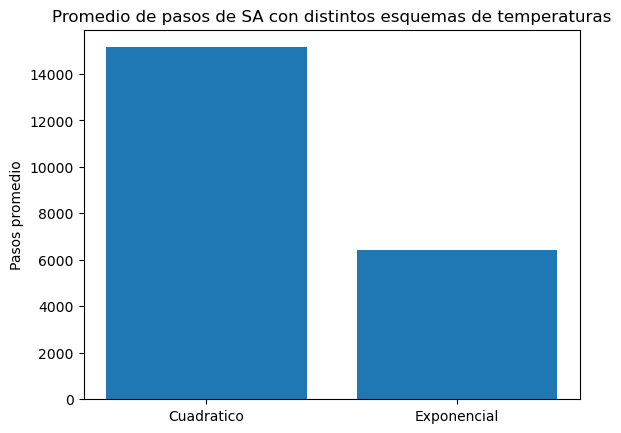

In [37]:
#Se grafican estadisticas
beta_str = ['Cuadratico', 'Exponencial']
plt.bar(beta_str, [vec_quad.mean(),vec_exp.mean()])
plt.title("Promedio de pasos de SA con distintos esquemas de temperaturas")
plt.ylabel("Pasos promedio")
plt.show()

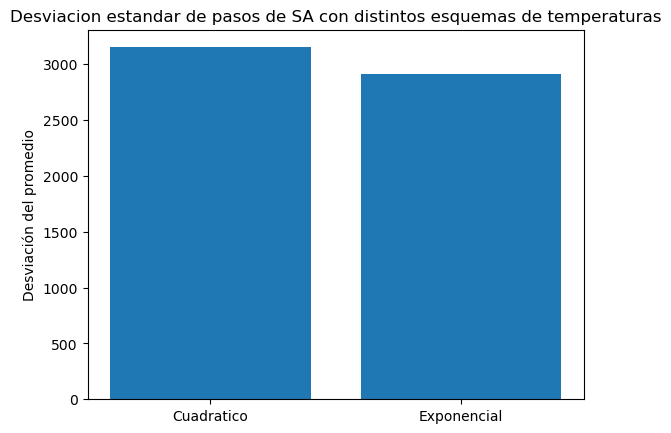

In [38]:
plt.bar(beta_str, [vec_quad.std(),vec_exp.std()])
plt.title("Desviacion estandar de pasos de SA con distintos esquemas de temperaturas")
plt.ylabel("Desviación del promedio")
plt.show()

## Probando en un grafo grande

In [39]:
#Elegimos g400 ya que tiene clique maximo 65
#Se ejecutara el algoritmo muchas veces, empezando de un clique de tamano 3 y se va aumentando
# se detiene cuando el algoritmo falla 5 veces seguidas
vec_stats = np.zeros(62) #Empieza desde 3
vec_times = np.zeros(62)

#max_step: cantidad maxima de iteraciones del algoritmo
max_step = 10000
#last_clique_size: ultimo tamano de clique que se termino de manera exitosa, a usarse en las proximas celdas
# para graficar correctamente
last_clique_size = 0
# end_flag: bandera que indica terminacion del loop
end_flag = False

for k in range(62):
    if end_flag: #Aviso de terminar loop
        break
    
    #Se inicializa un contador de cuantas veces falla el algoritmo y variables de medicion de tiempo
    contador = 0
    start = time.time()
    sigma, n = Decision_SA(k+3,max_step,nx.adjacency_matrix(gen400).todense(),beta_lol)
    end = time.time()
    
    #Se agregan las estadisticas al vector
    vec_stats[k] = n
    vec_times[k] = end-start
    
    #Condicion: algoritmo fallo
    while n == max_step-1:
        #Si falla mas de 5 veces, se activa la bandera
        if contador >= 5:
            end_flag = True
            print("Terminado en ", k+3)
            break
        contador += 1
        
        #Se vuelven a conseguir las estadisticas
        start = time.time()
        sigma, n = Decision_SA(k+3,max_step,nx.adjacency_matrix(gen400).todense(),beta_lol)
        end = time.time()

        vec_stats[k] = n
        vec_times[k] = end-start
    
    #Se define el last_clique_size
    if vec_stats[k] == max_step-1:
        last_clique_size = k+3

Terminado en  32


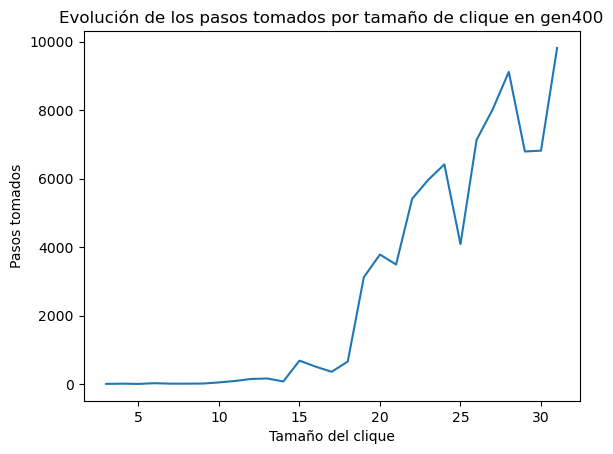

In [40]:
#Se grafica lo obtenido por la rutina anterior
plt.plot( np.arange(3,last_clique_size,1), vec_stats[0:last_clique_size-3])
plt.xlabel("Tamaño del clique")
plt.ylabel("Pasos tomados")
plt.title("Evolución de los pasos tomados por tamaño de clique en gen400")
plt.show()

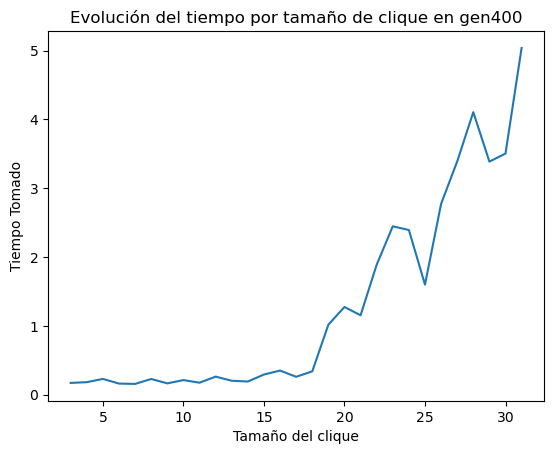

In [41]:
plt.plot( np.arange(3,last_clique_size,1), vec_times[0:last_clique_size-3])
plt.xlabel("Tamaño del clique")
plt.ylabel("Tiempo Tomado")
plt.title("Evolución del tiempo por tamaño de clique en gen400")
plt.show()

## Probando en grafos poco densos y grafos densos

In [42]:
#Obteniendo los grafos con la densidad deseada
#Se generan dos grafos aleatorios grandes, con densidades bajo/sobre umbrales deseados

#nodes_size: numero de nodos deseados
nodes_size = 750
#densidad: variable auxiliar que sera la densidad de los grafos a considerar
densidad = 0

#Se generan grafos aleatorios hasta que aparezca uno con la densidad deseada
while densidad < 0.65:
    G_denso = nx.fast_gnp_random_graph(nodes_size,0.85)
    L_denso = nx.adjacency_matrix(G_denso).todense()
    densidad = nx.density(G_denso)

densidad = 1
#Se generan grafos aleatorios hasta que aparezca uno con la densidad deseada
while densidad > 0.4:
    G_ligero = nx.fast_gnp_random_graph(nodes_size,0.15)
    L_ligero = nx.adjacency_matrix(G_ligero).todense()
    densidad = nx.density(G_ligero)
    
    
for node in G_denso.nodes():
    G_denso.nodes[node]['weight'] = 1
    
    
for node in G_ligero.nodes():
    G_ligero.nodes[node]['weight'] = 1

In [43]:

#Obtenenmos sus max cliques con un algoritmo exacto
#denso_clique = nx.algorithms.max_weight_clique(G_denso)[-1]
#ligero_clique = nx.algorithms.max_weight_clique(G_ligero)[-1]

#Mejor con el de aproximacion porque se estaba tardando demasiado
denso_clique = len(list(nx.approximation.max_clique(G_denso)))
ligero_clique = len(list(nx.approximation.max_clique(G_ligero)))

print("denso_clique: ", denso_clique)
print("ligero_clique: ", ligero_clique)

denso_clique:  34
ligero_clique:  5


In [44]:
#Buscando el clique del G denso
#Se ejecuta el algoritmo, una cantidad maxima de max_iter iteraciones, hasta que en algun momento
# el algoritmo termine de manera exitosa

#max_step: cantidad maxima de pasos del algoritmo
max_step = 10000
#contandor_denso: variable auxiliar que cuenta cuantas veces fallo el algoritmo
contador_denso = 0
#n_denso: variable que almacena cuantos pasos se tomo la ultima ejecucion del algoritmo
n_denso = max_step-1
#max_iter: cantidad maxima de iteraciones
max_iter = 25
while n_denso == max_step-1:
    sigma_denso, n_denso = Decision_SA(denso_clique,max_step,L_denso,beta_lol)
    contador_denso += 1
    if contador_denso >= max_iter:
        print("Se supero limite, forzando break del while")
        break

print("Se tuvo que ejecutar ", contador_denso, " veces el algoritmo para el grafo denso")

Se supero limite, forzando break del while
Se tuvo que ejecutar  25  veces el algoritmo para el grafo denso


In [45]:
#Buscando el clique del G denso
#La misma idea que antes, las variables representan lo mismo que sus correspondientes contrapartes densas
max_step = 10000
contador_ligero = 0
n_ligero = max_step-1
max_iter = 25
while n_ligero == max_step-1:
    sigma_denso, n_ligero = Decision_SA(ligero_clique,max_step,L_ligero,beta_lol)
    contador_ligero += 1
    if contador_ligero >= max_iter:
        print("Se supero limite, forzando break del while")
        break

print("Se tuvo que ejecutar ", contador_ligero, " veces el algoritmo para el grafo ligero")

Se tuvo que ejecutar  11  veces el algoritmo para el grafo ligero


# Primera implementación del SA para MaxClique

La idea es ejecutar el SA anterior, esta vez en un grafo de configuraciones gigante que consiste en la unión de todos los grafos de configuraciones considerados anteriormente, donde cada configuración sera una tupla de la forma $(\sigma,k)$, donde $\sigma$ es la permutación en juego y $k$ es el clique que se esta investigando en el momento del algoritmo, los vecinos de $(\sigma,k)$ son las tuplas de la forma $(\sigma,k+1),(\sigma,k-1),(\sigma,n-k),(\tau,k)$ donde $\tau$ es una configuración vecina de $\sigma$ en el grafo del SA original, se subentiende que la ultima etiqueta se toma modulo $n$, ie $0 = n$ donde $n$ es el número de nodos.

Este grafo no necesariamente es regular ya que el subgrafo asociado al k-clique tiene regularidad $(n-k)k$, por ende se forza a que sea regular añadiendo aristas entre los distintos sub grafos, esto es, se añaden las aristas necesarias entre el subgrafo $k$ y el subgrafo $n-k$, donde la cantidad de aristas necesarias son aquellas para alcanzar $ \max (n-k)k = floor(n/2) \cdot ceil(n/2)$, luego a cada nodo se agregan dos aristas adicionales que representan la transicion antes descrita

La función a optimizar en este caso es $H$, la cual es la suma de dos funciones $F_k$ y $p$ de acuerdo al siguente esquema

$$H(\sigma,k) = \alpha F _k(\sigma) + p(k)$$

Donde $F_k(\sigma)$ es la función que se minimizaba anteriormente para el problema de decisión de k-clique, y $p$ es una función de penalización que idealmente es inversamente proporcional al $k$, ie, los $k$ más cercano a $1$ (cliques más pequeños) tienen mayor peso., $\alpha \in \mathbb{R}$ es una sensibilidad ajustable.

In [46]:
#aca el esquema regular es el denominado esquema de Salto de la presentacion
# vecino_2 : Elige un vecino dado un sigma y un tamano de clique m
# el vecino puede ser una permutacion vecina con el mismo numero de clique
# o la misma permutacion con el numero de clique cambiado
#Este esquema de vecino es el que corresponde al Salto
# Aveces uso regular en vez de Salto por una confusion apriori que se tuvo
def vecino_2(sigma,m,A):
    n = A.shape[0]
    new_sig = sigma.copy()
    
    exp_max = np.ceil(n/2)*np.floor(n/2)
    
    
    #Se tira una bernoulli para decidir si transicionar a otro subgrafo o no
    
    s = np.random.binomial(1, (m*(n-m))/(exp_max+2) )  #Realmente hay que considerar si este p que estamos tomando es 
                                                 # demasiado pequeno, si es asi, se deben considerar otras formas
    u = np.random.randint(0,m)
    w = np.random.randint(m,n)
    contador = 0
    
    #Caso en que se elige un clique mayor y  no se cambia la permutacon considerada
    
    if s == 0: #Se cambia de clique
        #Ahora se debe decidir si se transiciona a m+1 o a n-m
        s = np.random.binomial(1, exp_max/(exp_max+2) )
        
        if s == 0:
            w = np.random.binomial(1, 0.5) #Se tira una moneda balanceada para elegir si se baja o sube
            if w == 2:
                if m == n-3:
                    return sigma, 3 #Notese que no llegamos a cliques de tamanos 2, ya que estos son solo aristas
                else:
                    return sigma, m+1
            else:
                if m == 3:
                    return sigma, n-3 #Tampoco se llega a cliques de tamanos n-2 n-1 n, se consideran casos apartes faciles de checkear
                else:
                    return sigma, m-1 
        else:
            return sigma, n-m #Aca el salto
    #Caso en que se cambia la permutacion considerada pero no se cambia el clique
    
    while F_prima(u,A,m) > F_prima(w,A,m):
        contador += 1
        if contador >= 8*n: # se acepta de todas formas
            break
            
        w = np.random.randint(m,n)
    
    new_sig[u] = sigma[w]
    new_sig[w] = sigma[u]
    
    return new_sig, m

#Checkea si el vector de numpy x se encuentra en un array arr, donde el array es una lista de python que contiene 
# vectores de numpy
def check_if_inside(x,arr):
    for vec in arr:
        if vec.size == x.size:
            if np.all( np.sort(vec) == x):
                return True
    
    return False
#count_cliques: Funcion de utilidad que recibe el oputput del SA y retorna cuantos cliques de cada tamaño se conto
def count_cliques(arr,n):
    arr_copy = arr.copy()
    k = 3 #Empezamos con clique 3
    counter = 0
    count_vec = np.zeros(n)
    while arr_copy != []:
        vec = arr_copy.pop()
        count_vec[ vec.size - 3] += 1

    
    return count_vec

#MaxClique_SA ( Grafo  regular)
#steps: cantidad de pasos
#A: matriz de adyacencia del grafo
#m_inicial: clique que se empieza buscando
#beta: funcion de temperaturas
#penalizacion:  funcion de la penalizacion de la funcion objetivo
#sensibilidad: alfa en la funcion objetivo
def MaxClique_SA(steps,A,m_inicial,beta, penalizacion,sensibilidad):
    #Inicializacion
    m = m_inicial
    sigma = gen_initial_perm(A)
    cost_clique = F(A,sigma,m)
    cost = sensibilidad*cost_clique + penalizacion(m)
    found_cliques_prema = []
    
    #Se comienza a iterar
    for n in range(steps):
        
        u = np.random.uniform(0, 1)
        
        #Se elige vecino
        sigma_new , m = vecino_2(sigma,m,A)
        
        #Se recuerda que si esto es costo 0, entonces tiene un clique de tamano m
        cost_clique =  F(A,sigma_new,m)
        cost_new = sensibilidad*cost_clique + penalizacion(m)
        
        if cost_clique == 0:
            #print("Se ha encontrado clique de tamaño ", m)
            #print(sigma_new[:m])
            found_cliques_prema.append( np.sort(sigma_new[:m]))

        cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))
            
        if u <= cte:
            sigma = sigma_new
            cost = cost_new
              

    found_cliques = []
    [found_cliques.append(x) for x in found_cliques_prema if not check_if_inside(x,found_cliques)]
    found_cliques
    
    return sigma_new, n, found_cliques

In [47]:
#Se elige una funcion de penalizacion
def p_1(k):
    return 1/(k**2)

In [48]:
#Se prueba el algoritmo con un grafo pequeño
sigma_lol, n_lol, fq = MaxClique_SA(100000,L,4,beta_lol,p_1,1)
count_cliques(fq,50)

array([211., 148.,  42.,  15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.])

In [49]:
# Probemos ahora con el grafo C125.9
ady = nx.adjacency_matrix(C125).todense()
start = time.time()
sigma_lol, n_lol,fq = MaxClique_SA(10000, ady, 9, beta_lol, p_1, 1)
end = time.time()
tiempo_reg = end - start
count_cliques(fq,250)

array([  0.,   0.,   0.,   0.,   0., 236.,  16.,  67.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

Si se considera un grafo no regular, que no tiene transiciciones del estilo $(\sigma, n-k)$, entonces obtenemos el algoritmo ''Naive'', el cual parece desempeñar mejor.

In [50]:

# vecino_3 : Elige un vecino dado un sigma y un tamano de clique m
# el vecino puede ser una permutacion vecina con el mismo numero de clique
# o la misma permutacion con el numero de clique cambiado
# este corresponde al esquema Naive
def vecino_3(sigma,m,A):
    n = A.shape[0]
    new_sig = sigma.copy()
    
    s = np.random.binomial(1, 1/(m*(n-m) + 1) )  #Realmente hay que considerar si este p que estamos tomando es 
                                                 # demasiado pequeno, si es asi, se deben considerar otras formas
    u = np.random.randint(0,m)
    w = np.random.randint(m,n)
    contador = 0
    
    #Caso en que se elige un clique mayor y  no se cambia la permutacon considerada
    
    if s == 1: #Se cambia de clique
        w = np.random.binomial(1, 0.5) #Se tira una moneda balanceada para elegir si se baja o sube
        if w == 2:
            if m == n-1:
                return sigma, 1
            else:
                return sigma, m+1
        else:
            if m == 3:
                return sigma, n-1
            else:
                return sigma, m-1
    
    #Caso en que se cambia la permutacion considerada pero no se cambia el clique
    
    while F_prima(u,A,m) > F_prima(w,A,m):
        contador += 1
        if contador >= 8*n: # se acepta de todas formas
            break
            
        w = np.random.randint(m,n)
    
    new_sig[u] = sigma[w]
    new_sig[w] = sigma[u]
    
    return new_sig, m
#MaxClique_SA (Naive)
#steps: cantidad de pasos
#A: matriz de adyacencia del grafo
#m_inicial: clique que se empieza buscando
#beta: funcion de temperaturas
#penalizacion:  funcion de la penalizacion de la funcion objetivo
#sensibilidad: alfa en la funcion objetivo
def MaxClique_SA_naive(steps,A,m_inicial,beta, penalizacion,sensibilidad):
    #Inicializacion
    m = m_inicial
    sigma = gen_initial_perm(A)
    cost_clique = F(A,sigma,m)
    cost = sensibilidad*cost_clique + penalizacion(m)
    found_cliques_prema = []
    
    #Se comienza a iterar
    for n in range(steps):
        
        u = np.random.uniform(0, 1)
        
        #Se elige vecino
        sigma_new , m = vecino_3(sigma,m,A)
        
        #Se recuerda que si esto es costo 0, entonces tiene un clique de tamano m
        cost_clique =  F(A,sigma_new,m)
        cost_new = sensibilidad*cost_clique + penalizacion(m)
        
        if cost_clique == 0:
            #print("Se ha encontrado clique de tamaño ", m)
            #print(sigma_new[:m])
            found_cliques_prema.append( np.sort(sigma_new[:m]))

        cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))
            
        if u <= cte:
            sigma = sigma_new
            cost = cost_new
              

    found_cliques = []
    [found_cliques.append(x) for x in found_cliques_prema if not check_if_inside(x,found_cliques)]
    found_cliques
    
    return sigma_new, n, found_cliques

In [51]:
#Se ejecuta en un grafo pequeno para testear
sigma_lol, n_lol, fq_2 = MaxClique_SA_naive(10000,L,4,beta_lol,p_1,1)
count_cliques(fq_2,50)

array([32.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [52]:
# Probemos ahora con el grafo C125.9
ady = nx.adjacency_matrix(C125).todense()
start = time.time()
sigma_lol, n_lol,fq_naive = MaxClique_SA_naive(10000, ady, 9, beta_lol, p_1, 1)
end  = time.time()
time_naive = end-start
count_cliques(fq_naive,250)

array([199., 906., 494., 221.,  50., 237., 150.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

#### Implementando una memoria tabu de corto plazo

In [53]:
#Checkea si el vector x se encuentra en arr, ignorando el sort pero respetando la division de m clique
def check_if_inside_ignore_sort(x,m,arr):
    x_1 = np.sort(x[:m])
    x_2 = np.sort(x[m:])
    for vec in arr:
        vec_1 = np.sort(vec[:m])
        vec_2 = np.sort(vec[m:])
        if np.all( np.sort(vec_1) == x_1) and np.all( np.sort(vec_2) == x_2):
            return True
    
    return False

#vecino_tabu: encuentra vecino segun el esquema Naive, pero lo rechaza si aquel vecino esta en la lista tabu
def vecino_tabu(sigma,m,A,tabulist):
    n = A.shape[0]
    new_sig = sigma.copy()
    
    s = np.random.binomial(1, 1/(m*(n-m) + 1) )  #Realmente hay que considerar si este p que estamos tomando es 
                                                 # demasiado pequeno, si es asi, se deben considerar otras formas
    u = np.random.randint(0,m)
    w = np.random.randint(m,n)
    contador = 0
    
    #Caso en que se elige un clique mayor y  no se cambia la permutacon considerada
    
    if s == 1: #Se cambia de clique
        w = np.random.binomial(1, 0.5) #Se tira una moneda balanceada para elegir si se baja o sube
        if w == 2:
            if m == n-1:
                return sigma, 1
            else:
                return sigma, m+1
        else:
            if m == 3:
                return sigma, n-1
            else:
                return sigma, m-1
    
    #Caso en que se cambia la permutacion considerada pero no se cambia el clique
    while F_prima(u,A,m) > F_prima(w,A,m) or check_if_inside_ignore_sort(new_sig,m,tabulist):
        contador += 1
        if contador >= 8*n: # se acepta de todas formas
            break
            
        w = np.random.randint(m,n)
    
        new_sig[u] = sigma[w]
        new_sig[w] = sigma[u]
    
    return new_sig, m

#La heuristica Naive con al adicion de la lista tabu
#steps: cantidad de pasos
#A: matriz de adyacencia del grafo
#m_inicial: clique que se empieza buscando
#beta: funcion de temperaturas
#penalizacion:  funcion de la penalizacion de la funcion objetivo
#sensibilidad: alfa en la funcion objetivo
#tabu_size: tamano de la lista tabu
def MaxClique_SA_naive_tabu(steps,A,m_inicial,beta, penalizacion,sensibilidad,tabu_size):
    #Inicializacion
    m = m_inicial
    sigma = gen_initial_perm(A)
    cost_clique = F(A,sigma,m)
    cost = sensibilidad*cost_clique + penalizacion(m)
    found_cliques_prema = []
    tabulist = []
    
    #Se comienza a iterar
    for n in range(steps):
        
        u = np.random.uniform(0, 1)
        
        #Se elige vecino
        sigma_new , m = vecino_tabu(sigma,m,A,tabulist)
        
        #Se recuerda que si esto es costo 0, entonces tiene un clique de tamano m
        cost_clique =  F(A,sigma_new,m)
        cost_new = sensibilidad*cost_clique + penalizacion(m)
        
        if cost_clique == 0:
            #print("Se ha encontrado clique de tamaño ", m)
            #print(sigma_new[:m])
            found_cliques_prema.append( np.sort(sigma_new[:m]))

        cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))
            
        if u <= cte:
            if len(tabulist) >= tabu_size:
                #Se popea el primer elemento de la lista
                tabulist.pop(0)
        
    
            #Se agrega el viejo elemento a la lista tabu
            
            tabulist.append(sigma)
              
            #Se actualiza
            sigma = sigma_new
            cost = cost_new
            


    found_cliques = []
    [found_cliques.append(x) for x in found_cliques_prema if not check_if_inside(x,found_cliques)]
    found_cliques
    
    return sigma_new, n, found_cliques

In [54]:
# Probemos ahora con el grafo C125.9
ady = nx.adjacency_matrix(C125).todense()
start = time.time()
sigma_lol, n_lol,fq_tabu = MaxClique_SA_naive_tabu(10000, ady, 9, beta_lol, p_1, 1,50)
end  = time.time()
time_tabu = end-start
count_cliques(fq_tabu,250)

array([128., 170., 130., 125.,  69.,  63.,   3.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [55]:
#find_first_zero:  Dada una array de numeros, encuentra el primer indice en que a partir de aquel indice
# todos los valores son 0, posiblemente falle si la array no presenta tal comportamiento
def find_first_zero(arr):
    n = len(arr)
    for k in range(n):
        if arr[n-k-1] != 0:
            return n-k
    
    return NaN

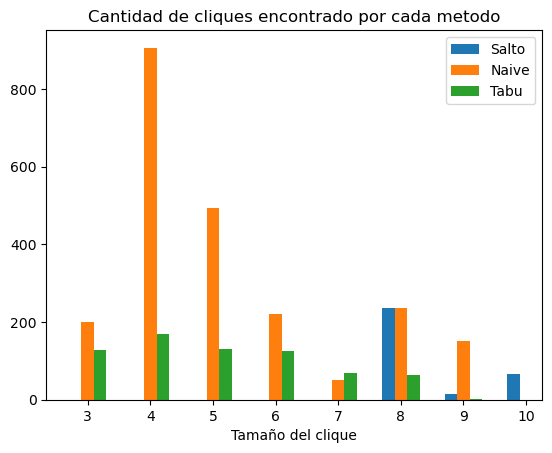

In [56]:
### Graficando los 3 metodos
reg_cliqs = count_cliques(fq,250)
naive_cliqs = count_cliques(fq_naive,250)
tabu_cliqs = count_cliques(fq_tabu,250)

zero_reg = find_first_zero(reg_cliqs)
zero_naive = find_first_zero(naive_cliqs)
zero_tabu = find_first_zero(tabu_cliqs)

plt.bar( np.arange(3,zero_reg+3) -0.2, reg_cliqs[:zero_reg],width=0.2, label = 'Salto')
plt.bar( np.arange(3,zero_naive+3), naive_cliqs[:zero_naive],width=0.2, label = 'Naive')
plt.bar( np.arange(3,zero_tabu+3) + 0.2, tabu_cliqs[:zero_tabu], width=0.2,label = 'Tabu')
plt.legend()
plt.title("Cantidad de cliques encontrado por cada metodo")
plt.xlabel("Tamaño del clique")
plt.show()

In [57]:
print("El tiempo tomado por el algoritmo con salto es: ", tiempo_reg)
print("El tiempo tomado por el algoritmo naive es: ", time_naive)
print("El tiempo tomado por el algoritmo tabu es : ", time_tabu)

El tiempo tomado por el algoritmo con salto es:  52.66349959373474
El tiempo tomado por el algoritmo naive es:  65.22522473335266
El tiempo tomado por el algoritmo tabu es :  134.33939790725708
